In [5]:
import surprise

import os
import numpy as np
import pandas as pd
import random
from deploy_on_test import deploy_on_test

DATA_PATH = 'data_movie_lens_100k/'

%load_ext autoreload
%autoreload 2

In [6]:
reader = surprise.Reader(
    line_format='user item rating', sep=',',
    rating_scale=(1, 5), skip_lines=1)

In [7]:
dev_set = surprise.Dataset.load_from_file(
    os.path.join(DATA_PATH, 'ratings_all_development_set.csv'), reader=reader)

In [8]:
raw_ratings = dev_set.raw_ratings.copy()

random.seed(135)
random.shuffle(raw_ratings)


raw_ratings = dev_set.raw_ratings

split_point = int(0.8 * len(raw_ratings))
train_raw = raw_ratings[:split_point]
test_raw = raw_ratings[split_point:]


train_trimmed = [(uid, iid, rating) for (uid, iid, rating, _) in train_raw]
test_trimmed  = [(uid, iid, rating) for (uid, iid, rating, _) in test_raw]

train_df = pd.DataFrame(train_trimmed, columns=["user", "item", "rating"])
test_df  = pd.DataFrame(test_trimmed, columns=["user", "item", "rating"])

train_data = surprise.Dataset.load_from_df(train_df, reader)
test_data  = surprise.Dataset.load_from_df(test_df, reader)

In [9]:
# to save compute
from surprise.model_selection import RandomizedSearchCV
from surprise import SVDpp



In [10]:
param_grid = {
    'lr_all': [0.003, 0.005, 0.007],
    'reg_all': [0.05, 0.1, 0.2, 0.3],
    'n_factors': [50, 75, 100],
    'n_epochs': [50, 100]
}

rs = RandomizedSearchCV(
    SVDpp, 
    param_grid,
    n_iter=10,             
    measures=['mae'], 
    cv=5,                 
    n_jobs=-1,             
    joblib_verbose=3,      
    refit=True,            
    return_train_measures=True
)


In [11]:
rs.fit(train_data)

""" 
params should be
array([{'lr_all': 0.003, 'reg_all': 0.05, 'n_factors': 75, 'n_epochs': 50},
       {'lr_all': 0.003, 'reg_all': 0.3, 'n_factors': 50, 'n_epochs': 50},
       {'lr_all': 0.005, 'reg_all': 0.3, 'n_factors': 50, 'n_epochs': 50},
       {'lr_all': 0.007, 'reg_all': 0.05, 'n_factors': 75, 'n_epochs': 100},
       {'lr_all': 0.007, 'reg_all': 0.2, 'n_factors': 75, 'n_epochs': 100},
       {'lr_all': 0.007, 'reg_all': 0.3, 'n_factors': 100, 'n_epochs': 50},
       {'lr_all': 0.003, 'reg_all': 0.2, 'n_factors': 50, 'n_epochs': 100},
       {'lr_all': 0.003, 'reg_all': 0.05, 'n_factors': 100, 'n_epochs': 50},
       {'lr_all': 0.007, 'reg_all': 0.3, 'n_factors': 50, 'n_epochs': 100},
       {'lr_all': 0.005, 'reg_all': 0.3, 'n_factors': 100, 'n_epochs': 50}],
      dtype=object) """

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.6min finished


" \nparams should be\narray([{'lr_all': 0.003, 'reg_all': 0.05, 'n_factors': 75, 'n_epochs': 50},\n       {'lr_all': 0.003, 'reg_all': 0.3, 'n_factors': 50, 'n_epochs': 50},\n       {'lr_all': 0.005, 'reg_all': 0.3, 'n_factors': 50, 'n_epochs': 50},\n       {'lr_all': 0.007, 'reg_all': 0.05, 'n_factors': 75, 'n_epochs': 100},\n       {'lr_all': 0.007, 'reg_all': 0.2, 'n_factors': 75, 'n_epochs': 100},\n       {'lr_all': 0.007, 'reg_all': 0.3, 'n_factors': 100, 'n_epochs': 50},\n       {'lr_all': 0.003, 'reg_all': 0.2, 'n_factors': 50, 'n_epochs': 100},\n       {'lr_all': 0.003, 'reg_all': 0.05, 'n_factors': 100, 'n_epochs': 50},\n       {'lr_all': 0.007, 'reg_all': 0.3, 'n_factors': 50, 'n_epochs': 100},\n       {'lr_all': 0.005, 'reg_all': 0.3, 'n_factors': 100, 'n_epochs': 50}],\n      dtype=object) "

In [12]:
# best_model = rs.best_estimator['mae']
best_model = SVDpp(lr_all=0.003, reg_all=0.05, n_factors=75, n_epochs=50)



In [13]:
# rs.best_params
# {'mae': {'lr_all': 0.003, 'reg_all': 0.05, 'n_factors': 75, 'n_epochs': 50}}


In [14]:
import surprise.accuracy

best_model.fit(train_data.build_full_trainset())

test_predictions = best_model.test(test_data.build_full_trainset().build_testset())

surprise.accuracy.mae(test_predictions)

MAE:  0.7296


0.7295842845450737

In [15]:
from joblib import Parallel, delayed

In [16]:
import os
# deploy_on_test(best_model)

a1 = np.loadtxt("predicted_ratings_leaderboard_gs.txt")
a2 = np.loadtxt("predicted_ratings_leaderboard_new.txt")

np.allclose(a1, a2, rtol=0.8)
# leaderboard metrics 0.7198 0.9173 0.8852 0.9412 4.1421 3.951

True

In [17]:
from surprise.model_selection import cross_validate

In [18]:
def make_trace_data(param_dict, epoch_list):
    
    def fit_and_eval(n_epochs):
        model = SVDpp(**param_dict, n_epochs=n_epochs)
            
        results = cross_validate(model, train_data, measures=['mae'], cv=5, return_train_measures=True)
            
        return n_epochs, results['train_mae'], results['test_mae']

    outputs = Parallel(n_jobs=-1, verbose=10)(
        delayed(fit_and_eval)(n_epochs) for n_epochs in epoch_list
        )
        
    train_maes = dict()
    test_maes = dict()
    
    for n_epochs, train_scores, test_scores in outputs:
        train_maes[n_epochs] = train_scores
        test_maes[n_epochs] = test_scores
    
    return train_maes, test_maes

In [19]:
train_maes, test_maes = make_trace_data(
    {"lr_all": 0.003, "reg_all": 0.05, "n_factors": 75}, np.arange(10, 55, 5)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [20]:
# Import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [21]:
def plot_model_metrics(param_dict, epoch_list, train_maes, test_maes):
    
    train_means = [np.mean(train_maes[ep]) for ep in epoch_list]
    train_stds  = [np.std(train_maes[ep])  for ep in epoch_list]
    test_means  = [np.mean(test_maes[ep])  for ep in epoch_list]
    test_stds   = [np.std(test_maes[ep])   for ep in epoch_list]

    plt.figure(figsize=(8, 5))

    # Plot train curve
    plt.plot(epoch_list, train_means, 'b.-', label='MAE on train')
    plt.fill_between(epoch_list,
                     np.array(train_means) - np.array(train_stds),
                     np.array(train_means) + np.array(train_stds),
                     color='blue', alpha=0.2)

    # Plot test curve
    plt.plot(epoch_list, test_means, 'r.-', label='MAE on valid')
    plt.fill_between(epoch_list,
                     np.array(test_means) - np.array(test_stds),
                     np.array(test_means) + np.array(test_stds),
                     color='red', alpha=0.2)
    plt.xlabel('epoch');
    plt.legend(loc='lower right');
    plt.title(f'Epoch vs MAE on train and val sets; {param_dict}')
    plt.ylim([np.min(train_means) - 0.2, 0.8])
    plt.show()
    plt.close()

In [ ]:

train_maes

{10: array([0.71552847, 0.71520986, 0.71346786, 0.71494859, 0.71332805]),
 15: array([0.69296827, 0.69508881, 0.69228499, 0.69331693, 0.69169888]),
 20: array([0.67429053, 0.67287256, 0.67404722, 0.67321323, 0.67463406]),
 25: array([0.6550879 , 0.65341549, 0.65446162, 0.65357214, 0.6526856 ]),
 30: array([0.63155679, 0.6338357 , 0.63035556, 0.6317145 , 0.63258015]),
 35: array([0.61102926, 0.61482132, 0.61072491, 0.61114765, 0.61164035]),
 40: array([0.58991272, 0.58960849, 0.58793191, 0.586556  , 0.58625521]),
 45: array([0.56341745, 0.56592368, 0.56748277, 0.56252831, 0.56497866]),
 50: array([0.54386484, 0.54139621, 0.5411133 , 0.54335782, 0.53937188])}

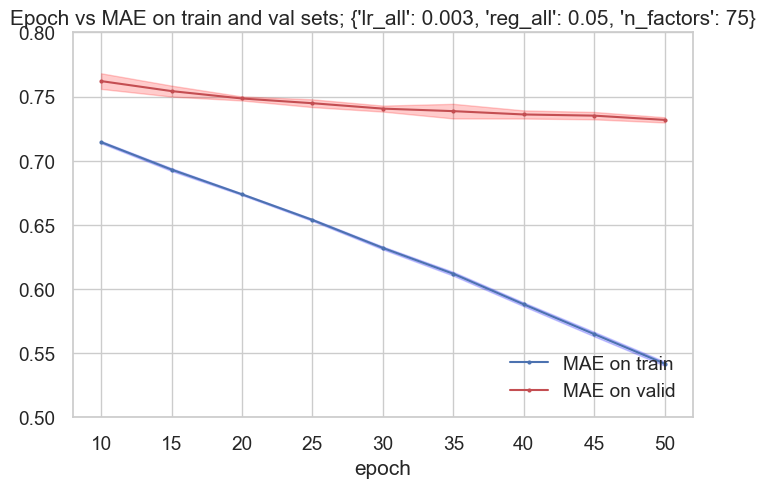

In [ ]:
plot_model_metrics({"lr_all": 0.003, "reg_all": 0.05, "n_factors": 75}, np.arange(10, 55, 5), train_maes, test_maes)

In [ ]:
train_maes, test_maes = make_trace_data(
    {"lr_all": 0.009, "reg_all": 0.1, "n_factors": 100}, np.arange(10, 55, 5)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s

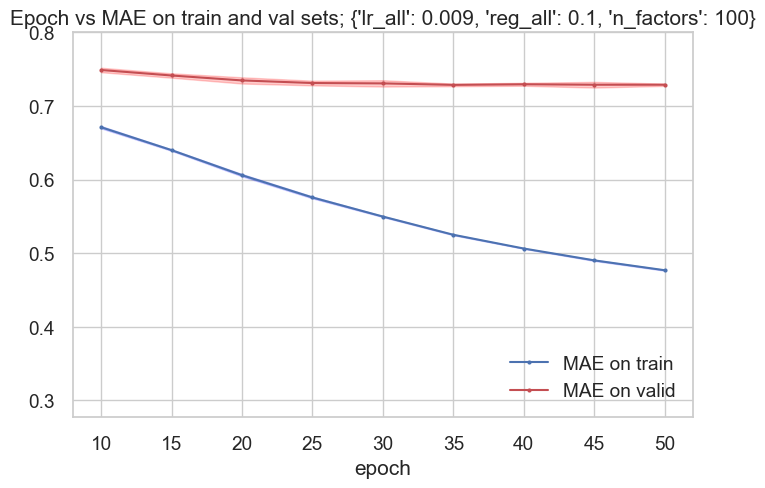

In [ ]:
plot_model_metrics({"lr_all": 0.009, "reg_all": 0.1, "n_factors": 100}, np.arange(10, 55, 5), train_maes, test_maes)

In [72]:
train_maes, test_maes = make_trace_data({"lr_all": 0.003, "reg_all": 0.05, "n_factors": 75}, np.arange(10, 51, 1))



plot_model_metrics({"lr_all": 0.003, "reg_all": 0.05, "n_factors": 75}, np.arange(10, 51, 1), train_maes, test_maes)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s

In [84]:
import pandas as pd

NUM_USERS = 943
NUM_ITEMS = 1682
def user_items(file_path, data_path="data_movie_lens_100k/"):
    ''' take in a path and a data path, and returns the item/user pairs of them 
    '''
    full_file_path = os.path.join(data_path, file_path)
    # Manually read user-item pairs
    user_item_pairs = []
    with open(full_file_path, "r") as f:
        next(f)  # Skip header
        for line in f:
            if line.strip() == "":
                continue
            user, item, _ = line.strip().split(",")
            user_item_pairs.append( (user, item) )
    return user_item_pairs
    # sanity check
# print(*user_item_pairs, sep='\n')

In [ ]:
test_file_path = "ratings_masked_leaderboard_set.csv"
train_file_path = "ratings_all_development_set.csv"

DATA_PATH = "data_movie_lens_100k/"

# how many movies each user rated
num_ratings_per_user = [0] * NUM_USERS
num_ratings_per_item = [0] * NUM_ITEMS


assert(len(num_ratings_per_user) == NUM_USERS)
assert(len(num_ratings_per_item) == NUM_ITEMS)
dev_user_item_pairs = user_items(train_file_path)
test_user_item_pairs = user_items(test_file_path)
for user, item in dev_user_item_pairs:
    num_ratings_per_item[int(item)] += 1
    num_ratings_per_user[int(user)] += 1

# taking the dev set as reference, what is the average ratings of 
avg_num_ratings_per_item_test = [0] * len(test_user_item_pairs)
avg_num_ratings_per_user_test = [0] * len(test_user_item_pairs)
for i, (user, item) in enumerate(test_user_item_pairs):
    avg_num_ratings_per_item_test[i] = num_ratings_per_item[int(item)]
    avg_num_ratings_per_user_test[i] = num_ratings_per_user[int(user)]
    
print(np.mean(avg_num_ratings_per_item_test))
print(np.mean(avg_num_ratings_per_user_test))


149.8205
181.2447


In [ ]:
num_ratings_per_user = [0] * NUM_USERS
num_ratings_per_item = [0] * NUM_ITEMS

for user, item in test_user_item_pairs:
    num_ratings_per_item[int(item)] += 1
    num_ratings_per_user[int(user)] += 1

# taking the test set as reference, what is the average ratings of 
avg_num_ratings_per_item_test = [0] * len(test_user_item_pairs)
avg_num_ratings_per_user_test = [0] * len(test_user_item_pairs)
for i, (user, item) in enumerate(test_user_item_pairs):
    avg_num_ratings_per_item_test[i] = num_ratings_per_item[int(item)]
    avg_num_ratings_per_user_test[i] = num_ratings_per_user[int(user)]
    
print(np.mean(avg_num_ratings_per_item_test))
print(np.mean(avg_num_ratings_per_user_test))

[13, 33, 40, 22, 21, 28, 4, 25, 39, 43, 14, 27, 9, 15, 3, 12, 3, 51, 12, 23, 25, 10, 3, 14, 23, 39, 10, 10, 28, 2, 5, 55, 22, 15, 5, 20, 7, 3, 10, 11, 51, 7, 19, 23, 3, 11, 28, 14, 10, 9, 46, 16, 5, 30, 8, 9, 27, 16, 5, 46, 9, 14, 20, 25, 20, 20, 9, 15, 2, 13, 16, 21, 15, 1, 30, 19, 11, 2, 26, 16, 2, 49, 55, 15, 25, 4, 10, 6, 3, 20, 3, 24, 23, 16, 9, 21, 9, 7, 19, 5, 10, 13, 29, 19, 7, 43, 38, 7, 12, 19, 5, 14, 1, 37, 8, 5, 6, 11, 4, 16, 4, 25, 15, 12, 2, 14, 11, 18, 36, 15, 13, 18, 19, 27, 15, 11, 8, 11, 25, 7, 17, 14, 21, 55, 21, 8, 8, 12, 10, 9, 10, 30, 2, 21, 50, 4, 14, 23, 16, 11, 4, 2, 20, 7, 22, 11, 11, 30, 7, 24, 25, 18, 16, 14, 2, 6, 6, 51, 45, 33, 20, 40, 12, 29, 11, 4, 4, 23, 33, 27, 27, 15, 5, 18, 43, 22, 21, 9, 40, 16, 24, 14, 25, 6, 7, 27, 6, 27, 20, 2, 26, 25, 9, 9, 8, 27, 13, 3, 10, 9, 11, 44, 28, 50, 2, 46, 20, 17, 25, 13, 28, 15, 14, 30, 34, 8, 20, 3, 32, 5, 15, 12, 22, 15, 16, 14, 21, 28, 23, 4, 17, 17, 28, 13, 35, 6, 3, 15, 1, 7, 49, 35, 26, 28, 3, 30, 11, 46, 11, 1